In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import *
from DSA.dsa import DSA
from matplotlib.colors import TwoSlopeNorm, Normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import *

# Load Data

In [3]:
norm = False
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'
grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [5]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [6]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [7]:
directory = pd.read_pickle(os.path.join(all_data_dir, data_class, f"{session}_lfp_chunked_20s", "directory"))

In [8]:
grid_results = compile_grid_results(session, grid_results_dir)

In [9]:
window, matrix_size, rank, all_results = combine_grid_results({'all': grid_results['all']})

In [10]:
n_delays = int(np.ceil(matrix_size/N))

# Testing Out DSA

In [44]:
window = 15

In [74]:
np.random.seed(43)
num_times = 5

wake_ts = np.random.uniform(section_times['wake'][0], section_times['wake'][1], size=(num_times, ))
anesthesia_ts = np.random.uniform(section_times['anesthesia'][0], section_times['anesthesia'][1], size=(num_times, ))

In [75]:
lfp_w = load_window_from_chunks(wake_ts[0], wake_ts[0] + window, directory=directory)
lfp_a = load_window_from_chunks(anesthesia_ts[0], anesthesia_ts[0] + window, directory=directory)

In [76]:
pca_w = PCA(n_components=50).fit(lfp_w)
pca_a = PCA(n_components=50).fit(lfp_a)

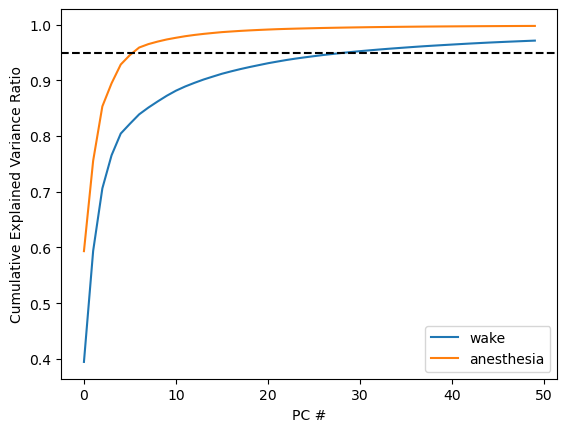

In [77]:
plt.plot(np.cumsum(pca_w.explained_variance_ratio_), label='wake')
plt.plot(np.cumsum(pca_a.explained_variance_ratio_), label='anesthesia')
plt.legend()
plt.xlabel('PC #')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(0.95, linestyle='--', c='k')
plt.show()

In [78]:
window_start_times = np.concatenate((wake_ts, anesthesia_ts))

In [79]:
n_delays = 15
rank = 375
pca_dims = 26

In [80]:
dissimilarity_mat = np.zeros((len(window_start_times), len(window_start_times)))
iterator = tqdm(total=int(len(window_start_times)*(len(window_start_times) - 1)/2))
for i, t1 in enumerate(window_start_times):
    lfp1 = load_window_from_chunks(t1, t1 + window, directory=directory)
    if pca_dims is not None:
        pca1 = PCA(n_components=pca_dims).fit(lfp1)
        lfp1 = pca1.transform(lfp1)
    for j, t2 in enumerate(window_start_times):
        if j > i:
            lfp2 = load_window_from_chunks(t2, t2 + window, directory=directory)
            if pca_dims is not None:
                pca2 = PCA(n_components=pca_dims).fit(lfp2)
                lfp2 = pca2.transform(lfp2)
            dsa = DSA(lfp1, lfp2, lr=1e-3, iters=3000, n_delays=n_delays, rank=rank, device='cuda', verbose=False)
            dissimilarity_mat[i, j] = dsa.fit_score()
            dissimilarity_mat[j, i] = dissimilarity_mat[i, j]
            iterator.update()
iterator.close()

  0%|          | 0/45 [00:00<?, ?it/s]

In [81]:
# lr_vals = [1e-4, 5e-4, 1e-3, 5e-3]
# iter_vals = [1500, 2000, 2500, 3000, 3500, 4000]

# iterator = tqdm(total=len(lr_vals)*len(iter_vals))

# dsa_objs = {}
# for lr in lr_vals:
#     dsa_objs[lr] = {}
#     for iters in iter_vals:
#         dsa_objs[lr][iters] = DSA(lfp1, lfp2, lr=lr, iters=iters, n_delays=n_delays, rank=rank, device='cuda', verbose=False)
#         dsa_objs[lr][iters].fit_score()
#         iterator.update()
# iterator.close()

# min_loss = np.Inf
# min_lr = None
# min_iters = None
# for lr in lr_vals:
#     for iters in iter_vals:
#         val = np.min(dsa_objs[lr][iters].simdist.losses)
#         if val < min_loss:
#             min_loss = val
#             min_lr = lr
#             min_iters = iters

# for lr in lr_vals:
#     if lr == 1e-3:
#         for iters in iter_vals:
#             plt.plot(dsa_objs[lr][iters].simdist.losses, label=f"lr={lr},iters={iters}")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.yscale('log')
# plt.show()

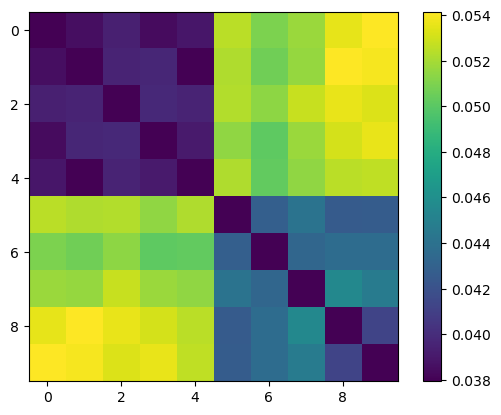

In [82]:
min_val = dissimilarity_mat[dissimilarity_mat > 0].min()
max_val = dissimilarity_mat[dissimilarity_mat > 0].max()
# min_val = dissimilarity_mat.min()
# max_val = dissimilarity_mat.max()
norm = Normalize(vmin=min_val, vmax=max_val)

plt.imshow(dissimilarity_mat, norm=norm)
plt.colorbar()

plt.show()

In [151]:
dissimilarity_mat

array([[0.        , 0.04432574, 0.07135352, 0.09986067],
       [0.04432574, 0.        , 0.11182935, 0.0767225 ],
       [0.07135352, 0.11182935, 0.        , 0.04659991],
       [0.09986067, 0.0767225 , 0.04659991, 0.        ]])

# Delase

In [201]:
np.random.seed(43)
num_times = 10

wake_ts = np.random.uniform(section_times['wake'][0], section_times['wake'][1], size=(num_times, ))
anesthesia_ts = np.random.uniform(section_times['anesthesia'][0], section_times['anesthesia'][1], size=(num_times, ))

In [202]:
window_start_times = np.concatenate((wake_ts, anesthesia_ts))

In [203]:
n_delays = 15
rank = 425

In [204]:
dissimilarity_mat = np.zeros((len(window_start_times), len(window_start_times)))
iterator = tqdm(total=len(window_start_times))

results = []

for i, t in enumerate(window_start_times):
    lfp = load_window_from_chunks(t, t + window, directory=directory)
    pca = PCA(n_components=26).fit(lfp)
    lfp = pca.transform(lfp)

    delase = DeLASE(lfp, n_delays=n_delays, rank=rank, max_freq=300, max_unstable_freq=125, dt=dt)
    delase.fit()

    results.append(dict(
        stability_params=delase.stability_params,
        stability_freqs=delase.stability_freqs,
    ))

    iterator.update()
iterator.close()

  0%|          | 0/20 [00:00<?, ?it/s]

In [205]:
def geo_mean(x):
    # return np.prod(x)**(1/len(x))
    return np.exp(np.log(x).mean())

def geo_se(x):
    print(len(x))
    return np.exp(np.log(x).std()/np.sqrt(len(x)))

302
288


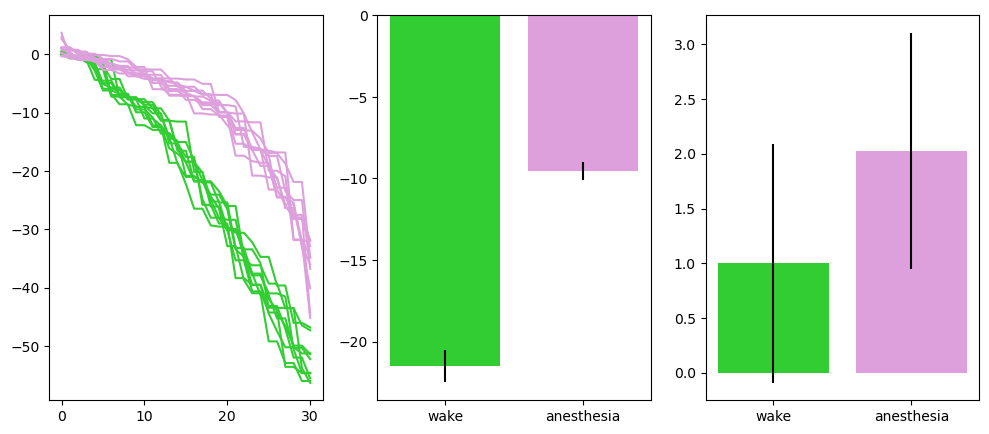

In [206]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
for i, ret in enumerate(results):
    if i < num_times:
        c = 'limegreen'
    else:
        c = 'plum'
    plt.plot(ret['stability_params'][:int(len(ret['stability_params'])*0.1)], c=c)

plt.subplot(1, 3, 2)
all_wake = np.hstack([ret['stability_params'][:int(len(ret['stability_params'])*0.1)] for ret in results[:num_times]])
all_anesthesia = np.hstack([ret['stability_params'][:int(len(ret['stability_params'])*0.1)] for ret in results[num_times:]])

heights = [all_wake.mean(), all_anesthesia.mean()]
errs = [all_wake.std()/np.sqrt(len(all_wake)), all_anesthesia.std()/np.sqrt(len(all_anesthesia))]
plt.bar(['wake', 'anesthesia'], height=heights, yerr=errs,color=['limegreen', 'plum'])

plt.subplot(1, 3, 3)
# wake_means = np.array([geo_mean(-1/ret['stability_params'].numpy()[:int(0.1*len(ret['stability_params']))][ret['stability_params'][:int(0.1*len(ret['stability_params']))] < 0]) for ret in results[:num_times]])
# baseline = geo_mean(wake_means)
# wake_to_baseline = np.array([geo_mean((-1/ret['stability_params'].numpy()[:int(0.1*len(ret['stability_params']))][ret['stability_params'][:int(0.1*len(ret['stability_params']))] < 0])/baseline) for ret in results[:num_times]])
# anesthesia_to_baseline = np.array([geo_mean((-1/ret['stability_params'].numpy()[:int(0.1*len(ret['stability_params']))][ret['stability_params'][:int(0.1*len(ret['stability_params']))] < 0])/baseline) for ret in results[num_times:]])

all_wake = np.hstack([-1/ret['stability_params'].numpy()[:int(0.1*len(ret['stability_params']))][ret['stability_params'][:int(0.1*len(ret['stability_params']))] < 0] for ret in results[:num_times]])
all_anesthesia = np.hstack([-1/ret['stability_params'].numpy()[:int(0.1*len(ret['stability_params']))][ret['stability_params'][:int(0.1*len(ret['stability_params']))] < 0] for ret in results[num_times:]])
baseline = geo_mean(all_wake)
wake_to_baseline = all_wake/baseline
anesthesia_to_baseline = all_anesthesia/baseline

heights = [geo_mean(wake_to_baseline), geo_mean(anesthesia_to_baseline)]
errs = [geo_se(wake_to_baseline), geo_se(anesthesia_to_baseline)]
plt.bar(['wake', 'anesthesia'], height=heights, yerr=errs, color=['limegreen', 'plum'])




plt.show()

# Testing DMD

In [32]:
from DSA.dmd import DMD

In [35]:
device = 'cuda'

In [56]:
dmd = DMD(lfp, n_delays=25, rank=None, device=device, verbose=True)

In [57]:
dmd.compute_hankel()
dmd.compute_svd()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!


In [58]:
%%time
dmd.rank = 10
dmd.compute_havok_dmd()

Computing least squares fits to HAVOK DMD ...
Least squares complete! 

CPU times: user 1.13 ms, sys: 40 µs, total: 1.17 ms
Wall time: 1.01 ms


In [59]:
print(dmd.A_v.shape)

torch.Size([10, 10])


In [60]:
%%time
dmd.rank = 25
dmd.compute_havok_dmd()

Computing least squares fits to HAVOK DMD ...
Least squares complete! 

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.18 ms


In [61]:
print(dmd.A_v.shape)

torch.Size([25, 25])


In [55]:
isinstance([1, 2, 3], list)

True